In [21]:
from exps.gpt2 import GPT2Wrapper
from typing import Any
import functools
import torch
import numpy as np
import time
import os
from torch.profiler import profile, record_function, ProfilerActivity

# inference_max_len = 50 # 每个输入用于推理的句子的最大长度

class Model(GPT2Wrapper):
    def __init__(self, model_name, inference_max_len):
        super().__init__(model_name)
        self.iml = inference_max_len

    def register_forward_hook(self, container: Any):
        def get_h0_input(module, input, output, container):
            container[:, 0] = input[0][0, :self.iml].detach()

        def hook(module, input, output, i, container):
            container[:, i + 1] = output[0][0, :self.iml].detach()
        
        handle = self.model.transformer.h[0].register_forward_hook(
            functools.partial(get_h0_input, container=container)
        )
        self.handles.append(handle)

        for i in range(self.n_layer):
            handle = self.model.transformer.h[i].register_forward_hook(
                functools.partial(hook, i=i, container=container)
            )
            self.handles.append(handle)

        # 传进来一个 max_len * (n_layer + 1) 的 tensor
        # 第 1～n_layer 行是 h0～hn 的输出
        # 第 0 行是 h0 的输入
            
    def task_inference(self, input):
        input_tokens = input.split(' ')
        input_tokens = input_tokens[:self.iml*2]
        input = ' '.join(input_tokens)
        # check if input > max_len tokens
        token_num = self.encode_input(input).shape[1]
        if token_num < self.iml:
            return None
        
        container = torch.zeros(self.iml, self.n_layer + 1, self.n_embd)
        container = self.inference(input, container) # [max_len, n_layer + 1, n_embd]
        original_shape = container.shape
        container = container.view(original_shape[0] * original_shape[1], original_shape[2]) # [max_len * (n_layer + 1), n_embd]

        # 现在 container 相当于是 max_len * (n_layer + 1) 个向量，每个向量是 n_embd 维的
        # 现在希望再拓展两个维度，变成 max_len * (n_layer + 1) 个 (n_embd + 2) 维的向量，后两维分别是 layer 和 position

        layer = torch.arange(self.n_layer + 1).repeat(self.iml).view(-1, 1).float() # [max_len * (n_layer + 1), 1]
        position = torch.arange(self.iml).repeat(self.n_layer + 1).view(-1, 1).float() # [max_len * (n_layer + 1), 1]
        container = torch.cat([container, layer, position], dim=1) # [max_len * (n_layer + 1), n_embd + 2]

        # 现在 container 是 max_len * (n_layer + 1) 个 (n_embd + 2) 维的向量
        return container

from torchtext import datasets
import random

def make_dataset(num, dataset='IMDB'):
    if dataset == 'IMDB':
        train_iter, _ = datasets.IMDB()
        train_data = list(train_iter)
        train_data: list[str] = [x[1] for x in train_data]
    else:
        raise ValueError('Unknown dataset')

    datapoints_num = len(train_data)

    assert num <= datapoints_num, 'Number of datapoints is too large'

    random.shuffle(train_data)
    train_data = train_data[:num]

    return train_data

import torch
from torch import nn, optim
from torch.utils.data import DataLoader, TensorDataset
from sklearn.model_selection import train_test_split
from tqdm.notebook import tqdm
from matplotlib import pyplot as plt

config = {
    'model_name': 'gpt2-medium',
    'inference_max_len': 30,
    'dataset_datapoints_num': 1000
}

model_name = config['model_name']
inference_max_len = config['inference_max_len']
dataset_datapoints_num = config['dataset_datapoints_num']

# 创建模型
model = Model(model_name, inference_max_len)
tokenizer = model.tokenizer

# 数据集创建
train_data = make_dataset(dataset_datapoints_num)
dataset = torch.zeros(dataset_datapoints_num * inference_max_len * (model.n_layer + 1), model.n_embd + 2).cuda()
processed_idx = 0

for i, x in enumerate(train_data):
    container = model.task_inference(x)
    if container is None:
        print(f'Warning: {i}th data is too short')
        continue

    dataset[processed_idx:processed_idx+inference_max_len*(model.n_layer+1)] = container
    processed_idx += inference_max_len * (model.n_layer + 1)

dataset = dataset[:processed_idx]

X = dataset[:, :-2]
print(X.shape)
Y = dataset[:, -2]
print(Y.shape)

# X normalization
X = (X - X.mean(dim=0)) / X.std(dim=0)

# # 让X的每一行的范数为1
# X = X / torch.norm(X, dim=1, keepdim=True)

#######
num_classes = model.n_layer + 1  # 类别数
norms = torch.norm(X, dim=1)  # 计算所有向量的L2范数
average_norms = []
var = []

for i in range(num_classes):
    class_mask = Y == i
    class_norms = norms[class_mask]
    average_norms.append(class_norms.mean().item())

    # 计算方差
    var.append(class_norms.var().item())

for i in range(X.shape[0]):
    # X的类别是多少？
    label = int(Y[i].item())
    # 根据正态分布来选取这一个样本的范数
    normal = torch.normal(average_norms[label], var[label], size=(1,)).item()
    # 随机生成一个[0,2]均匀分布的X.shape[1]维度的向量
    random_vector = torch.rand(X.shape[1]) * 2
    # 让这个向量的范数为normal
    random_vector = random_vector / torch.norm(random_vector) * normal
    # 将X[i]替换为这个向量
    X[i] = random_vector

#######

# 训练线性回归模型
n_samples, n_features = config['dataset_datapoints_num'], model.n_embd  # 样本数和特征数
n_classes = model.n_layer + 1  # 类别数

X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.2, random_state=42)
# X_train = X_train.cpu()
# X_test = X_test.cpu()
Y_train = Y_train.long()
Y_test = Y_test.long()

torch.Size([747750, 1024])
torch.Size([747750])


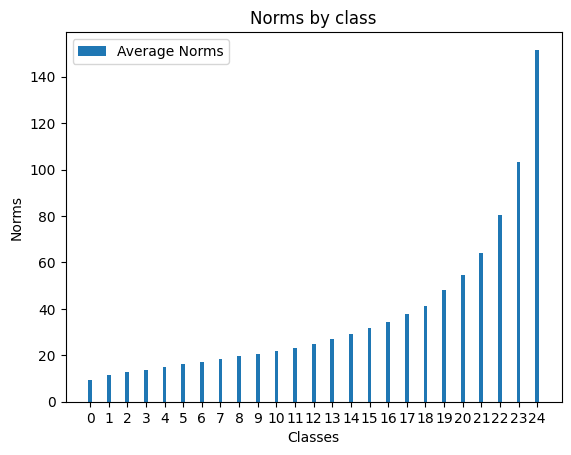

In [22]:
#######
num_classes = model.n_layer + 1  # 类别数
norms = torch.norm(X, dim=1)  # 计算所有向量的L2范数
average_norms = []

for i in range(num_classes):
    class_mask = Y == i
    class_norms = norms[class_mask]
    average_norms.append(class_norms.mean().item())

# 绘制柱状图
ind = np.arange(num_classes)  # 类别标签的位置
width = 0.2  # 柱状图的宽度

fig, ax = plt.subplots()
rects2 = ax.bar(ind, average_norms, width, label='Average Norms')

ax.set_xlabel('Classes')
ax.set_ylabel('Norms')
ax.set_title('Norms by class')
ax.set_xticks(ind)
ax.set_xticklabels(range(num_classes))
ax.legend()

plt.show()

#######

  0%|          | 0/1000 [00:00<?, ?it/s]

Accuracy: 0.05366098294884654 cfg =  {'model_name': 'gpt2-medium', 'inference_max_len': 30, 'dataset_datapoints_num': 1000}


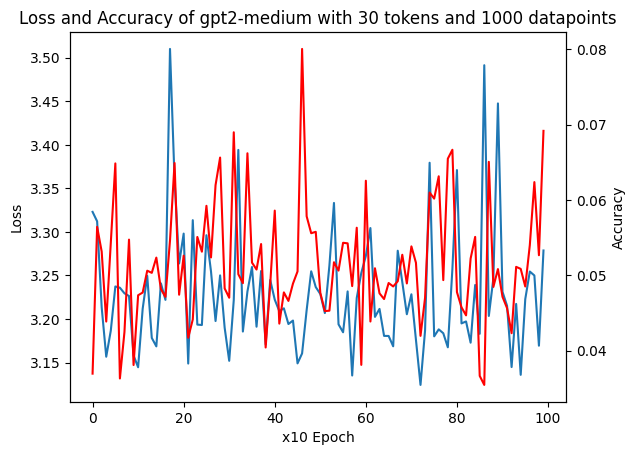

In [23]:
# 定义模型
class LogisticRegressionModel(nn.Module):
    def __init__(self, n_input_features, n_output_classes):
        super(LogisticRegressionModel, self).__init__()
        self.linear = nn.Linear(n_input_features, n_output_classes)

    def forward(self, x):
        return self.linear(x)

model = LogisticRegressionModel(n_features, n_classes).cuda()

# 损失函数和优化器
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr=0.01)

# 训练模型
n_epochs = 1000  # 训练轮数
batch_size = 1024  # 批处理大小
n_samples = X_train.size(0)  # 样本数
# use tqdm to show progress, and collect loss, draw a loss curve finally
loss_list = []
acc_list = []
for epoch in tqdm(range(n_epochs)):
    indices = torch.randperm(n_samples)
    X_train = X_train[indices]
    Y_train = Y_train[indices]

    for i in range(0, n_samples, batch_size):
        # 计算批处理的结束索引
        end = min(i + batch_size, n_samples)
        
        # 选取当前批次的数据并迁移至GPU
        X = X_train[i:end]
        Y = Y_train[i:end]
        # forward pass
        start = time.time()
        Yhat = model(X)
        loss = criterion(Yhat, Y)

        # backward pass
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

    if epoch % 10 == 0:
        loss_list.append(loss.item())
        Y_test_hat = model(X_test)
        _, Y_test_hat = Y_test_hat.max(1)
        acc = (Y_test_hat == Y_test).sum().item() / Y_test.size(0)
        acc_list.append(acc)

# 训练完毕，创建一个新的画布，绘制 loss 曲线（左）和 accuracy 曲线（右）
plt.figure()
plt.xlabel('x10 Epoch')
plt.ylabel('Loss')
plt.plot(loss_list)
plt.twinx()
plt.ylabel('Accuracy')
plt.plot(acc_list, 'r')
plt.title(f'Loss and Accuracy of {model_name} with {inference_max_len} tokens and {dataset_datapoints_num} datapoints')
plt.savefig(f'loss_{model_name}_{inference_max_len}_{dataset_datapoints_num}.png')

# 测试模型
model.eval()
with torch.no_grad():
    Yhat = model(X_test)
    _, Yhat = Yhat.max(1)
    accuracy = (Yhat == Y_test).sum().item() / Y_test.size(0)
    print(f'Accuracy: {accuracy}', "cfg = ", config)